In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from time import time
register_matplotlib_converters()

In [55]:
catfish_sales=pd.read_csv('catfish.csv',parse_dates=[0],index_col=0,date_format='%Y-%m-%d').squeeze()

In [56]:
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))


In [57]:
# getting data form 2000 onwards
start_date=pd.to_datetime('2000-1-1')
end_date=pd.to_datetime('2004-1-1')
lim_catfish_sales = catfish_sales[start_date:end_date]

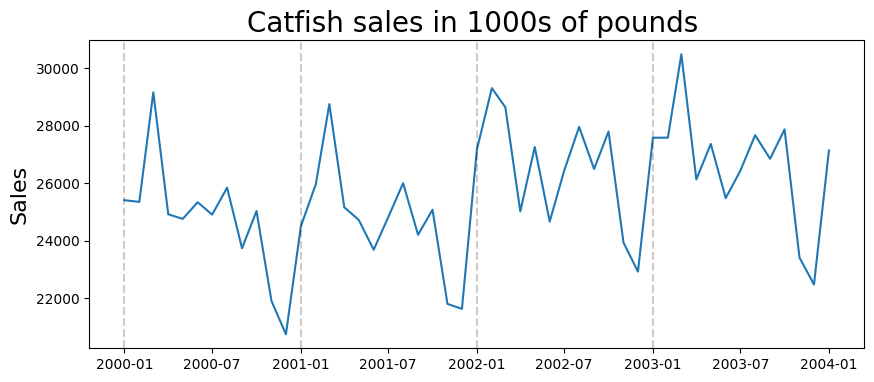

In [58]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish sales in 1000s of pounds ',fontsize=20)
plt.ylabel('Sales',fontsize=16)
for year in range(2000,2004):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

In [59]:
first_diff = lim_catfish_sales.diff()[1:]

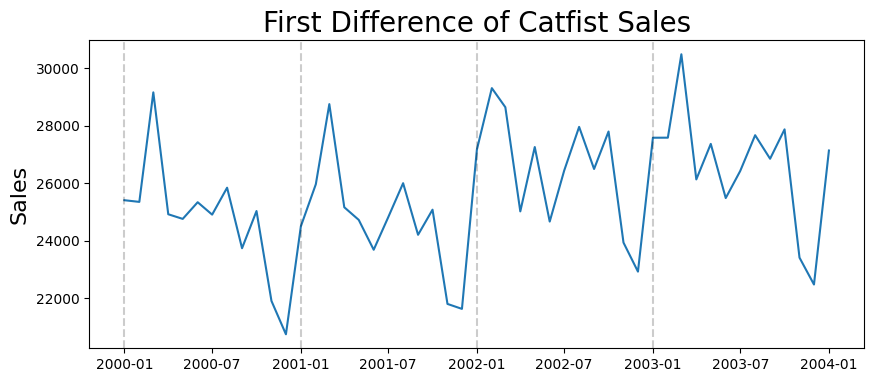

In [60]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('First Difference of Catfist Sales',fontsize=20)
plt.ylabel('Sales',fontsize=16)
for year in range(2000,2004):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

## $ACF$

<BarContainer object of 17 artists>

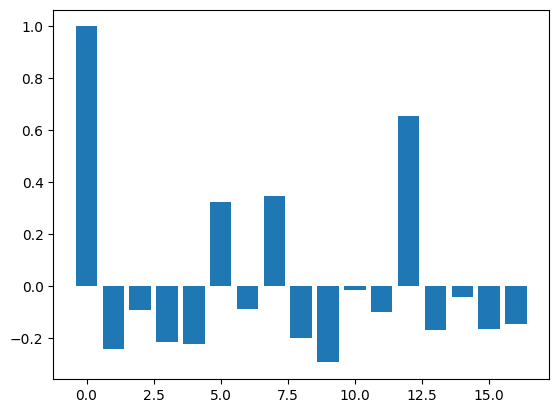

In [61]:
acf_vals=acf(first_diff)
num_lags=len(acf_vals)
plt.bar(range(num_lags),acf_vals[:num_lags])

> based on acf we should try MA(1) precess

## $PACF$

<BarContainer object of 17 artists>

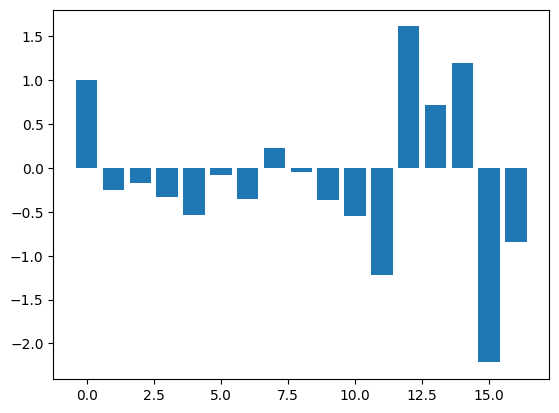

In [62]:
pacf_vals=pacf(first_diff)
p_num_lags=len(pacf_vals)
plt.bar(range(p_num_lags),pacf_vals[:p_num_lags])

> Based on pacf we should try AR(4) process

### Getting testing and training data

In [63]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

Definig and fitting the ARMA model

In [64]:
# define the model
model=ARIMA(train_data,order=(4,0,1))

In [65]:
# fit the model
start_time=time()
model_fit=model.fit()
end_time=time()
print('ARMA Model Training time:',end_time-start_time)

ARMA Model Training time: 0.1321728229522705


In [66]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -376.598
Date:                Sat, 09 Mar 2024   AIC                            767.195
Time:                        19:58:24   BIC                            779.359
Sample:                    02-01-2000   HQIC                           771.654
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1795    179.935      0.134      0.893    -328.487     376.846
ar.L1         -0.8659      0.222     -3.896      0.000      -1.302      -0.430
ar.L2         -0.4234      0.246     -1.724      0.0

## So the ARMA(4,1) model is:

## $\hat{y_t} = -0.86y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [67]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [68]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

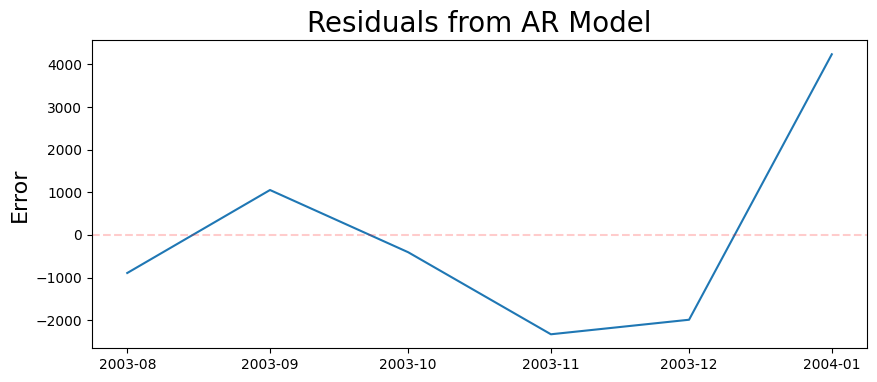

In [69]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

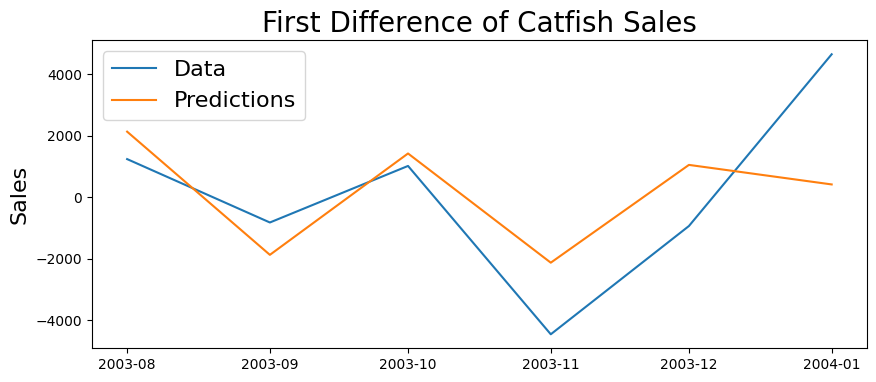

In [70]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [71]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2214.6996932969023
